<a href="https://colab.research.google.com/github/saritmaitra/Trading-strategy/blob/master/xgb_trading_Nasdaq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, r2_score
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
import warnings
import seaborn as sns
sns.set()
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!pip install pyforest
from pyforest import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import pandas_datareader as web
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
plt.style.use('ggplot')

  Created wheel for pyforest: filename=pyforest-1.0.3-py2.py3-none-any.whl size=13715 sha256=55f95ef2b05e01d7efb6889443d9c323feab072a023ffeec1a26ebf5ecffb8eb
  Stored in directory: /root/.cache/pip/wheels/af/0b/39/340a7f15fc8d4ff5ab50847b28789afea04452a9d51b9721b5
Successfully built pyforest


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
dataset = web.DataReader('^IXIC', data_source = 'yahoo', start = '2000-01-01')
print(dataset.head())
print('\n')
print(dataset.shape)

                   High          Low         Open        Close      Volume    Adj Close
Date                                                                                   
2000-01-03  4192.189941  3989.709961  4186.189941  4131.149902  1510070000  4131.149902
2000-01-04  4073.250000  3898.229980  4020.000000  3901.689941  1511840000  3901.689941
2000-01-05  3924.209961  3734.870117  3854.350098  3877.540039  1735670000  3877.540039
2000-01-06  3868.760010  3715.620117  3834.439941  3727.129883  1598320000  3727.129883
2000-01-07  3882.669922  3711.090088  3711.090088  3882.620117  1634930000  3882.620117


(5158, 6)


In [61]:
dataset.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-06-26,10000.669922,9749.070312,9995.120117,9757.219727,7279230000,9757.219727
2020-06-29,9877.339844,9663.610352,9771.719727,9874.150391,4306120000,9874.150391
2020-06-30,10085.589844,9863.669922,9875.290039,10058.769531,4474000000,10058.769531
2020-07-01,10197.190430,10048.040039,10063.669922,10154.629883,4595970000,10154.629883
2020-07-02,10310.360352,10194.059570,10268.669922,10207.629883,4017530000,10207.629883


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

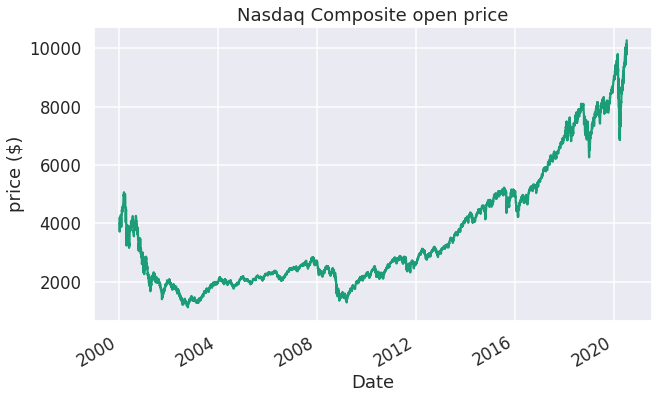

In [62]:
# Plot the closing prices for `aapl`
dataset['Open'].plot(grid=True, figsize=(10, 6))
plt.title('Nasdaq Composite open price')
plt.ylabel('price ($)')
# Show the plot
plt.show()

In [ ]:
# resetting index 
dataset.reset_index(inplace = True) 
# display 
print(dataset.head()) 

In [ ]:
dataset = dataset.sort_values(by = ['Date'], ascending=True)
print(dataset.head())

### ***Predictors***
We are going to omit High, Low and Open, using only Open and Volume for the study. Let’s start preparing the data for the analysis. The predictors (X variables) to be used to predict the target magnitued (y variable) will be the following ones:

Two day simple moving average (SMA2). The formula is (Ct – Ct-1)/2, being Ct equal to current day’s open price and Ct-1 to previous day’s open price. This formula is applied to each row of the data set.

### 1 day window SMA2. The previous day’s SMA2 value.

And the other predictors will be:

- Current day SMA2 increment. (SMA2t – SMA2t-1).
- 1 day window SMA2 increment. (SMA2t-1 – SMA2t-2).
- Current day volume increment. (Volt – Volt-1).
- Current day volume rate of change. (Volt – Volt-1)/Volt
- 1 day window open price. (Ct-1)
- Current day open price increment. Ct – Ct-1
- Current day open price. Ct.

In [63]:
p = dataset['Open'].rolling(window=2).mean()

dataset['ma1'] = p.diff()
dataset['ma2'] = dataset['ma1'].diff()
dataset['ma3'] = dataset['ma2'].diff()
dataset['HL'] = (dataset['High'] - dataset['Close']) / dataset['Close'] * 100
dataset['pct_change'] = (dataset['Close'] - dataset['Open']) / dataset['Open'] * 100
dataset['vol_increment'] = dataset.Volume.diff() / dataset.Volume
#dataset["vol_roc"] = dataset.Volume.diff() / dataset.Volume
dataset["open1"] = dataset.Open.shift(1)
dataset["open_increment"] = dataset.Open - dataset.Open.shift(1)

print(dataset.head())
print(dataset.shape)

                   High          Low         Open        Close      Volume    Adj Close         ma1        ma2        ma3        HL  pct_change  \
Date                                                                                                                                              
2000-01-03  4192.189941  3989.709961  4186.189941  4131.149902  1510070000  4131.149902         NaN        NaN        NaN  1.477556   -1.314800   
2000-01-04  4073.250000  3898.229980  4020.000000  3901.689941  1511840000  3901.689941         NaN        NaN        NaN  4.397071   -2.943036   
2000-01-05  3924.209961  3734.870117  3854.350098  3877.540039  1735670000  3877.540039 -165.919922        NaN        NaN  1.203596    0.601656   
2000-01-06  3868.760010  3715.620117  3834.439941  3727.129883  1598320000  3727.129883  -92.780029  73.139893        NaN  3.799978   -2.798585   
2000-01-07  3882.669922  3711.090088  3711.090088  3882.620117  1634930000  3882.620117  -71.630005  21.150024 -51.989

In [64]:
dataset = dataset[['ma1', 
                   'ma2',
                   'ma3', 
                   'HL', 
                   'pct_change', 
                   'vol_increment', 
                   'open1', 
                   'open_increment', 
                   'Open']]
print(dataset.head())

                   ma1        ma2        ma3        HL  pct_change  vol_increment        open1  open_increment         Open
Date                                                                                                                       
2000-01-03         NaN        NaN        NaN  1.477556   -1.314800            NaN          NaN             NaN  4186.189941
2000-01-04         NaN        NaN        NaN  4.397071   -2.943036       0.001171  4186.189941     -166.189941  4020.000000
2000-01-05 -165.919922        NaN        NaN  1.203596    0.601656       0.128959  4020.000000     -165.649902  3854.350098
2000-01-06  -92.780029  73.139893        NaN  3.799978   -2.798585      -0.085934  3854.350098      -19.910156  3834.439941
2000-01-07  -71.630005  21.150024 -51.989868  0.001283    4.622093       0.022392  3834.439941     -123.349854  3711.090088


In [65]:
dataset.fillna(-99999, inplace = True)
print(dataset.head())

                     ma1           ma2           ma3        HL  pct_change  vol_increment         open1  open_increment         Open
Date                                                                                                                                
2000-01-03 -99999.000000 -99999.000000 -99999.000000  1.477556   -1.314800  -99999.000000 -99999.000000   -99999.000000  4186.189941
2000-01-04 -99999.000000 -99999.000000 -99999.000000  4.397071   -2.943036       0.001171   4186.189941     -166.189941  4020.000000
2000-01-05   -165.919922 -99999.000000 -99999.000000  1.203596    0.601656       0.128959   4020.000000     -165.649902  3854.350098
2000-01-06    -92.780029     73.139893 -99999.000000  3.799978   -2.798585      -0.085934   3854.350098      -19.910156  3834.439941
2000-01-07    -71.630005     21.150024    -51.989868  0.001283    4.622093       0.022392   3834.439941     -123.349854  3711.090088


In [ ]:
#print(Predictors.head())

### ***Target Variable***
This will be a classification variable, if the average price will go either up or down the next day.  The target will be forecasting the difference between today’s price and tomorrow’s price (which is unkonwn).

In [66]:
dataset['target'] = (dataset.ma1.shift(-1) - dataset.ma1).dropna()
print(dataset.head())

                     ma1           ma2           ma3        HL  pct_change  vol_increment         open1  open_increment         Open        target
Date                                                                                                                                              
2000-01-03 -99999.000000 -99999.000000 -99999.000000  1.477556   -1.314800  -99999.000000 -99999.000000   -99999.000000  4186.189941      0.000000
2000-01-04 -99999.000000 -99999.000000 -99999.000000  4.397071   -2.943036       0.001171   4186.189941     -166.189941  4020.000000  99833.080078
2000-01-05   -165.919922 -99999.000000 -99999.000000  1.203596    0.601656       0.128959   4020.000000     -165.649902  3854.350098     73.139893
2000-01-06    -92.780029     73.139893 -99999.000000  3.799978   -2.798585      -0.085934   3854.350098      -19.910156  3834.439941     21.150024
2000-01-07    -71.630005     21.150024    -51.989868  0.001283    4.622093       0.022392   3834.439941     -123.34985

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

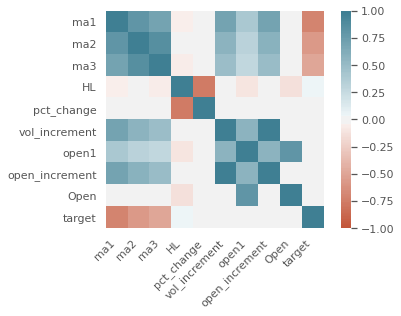

In [18]:
corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

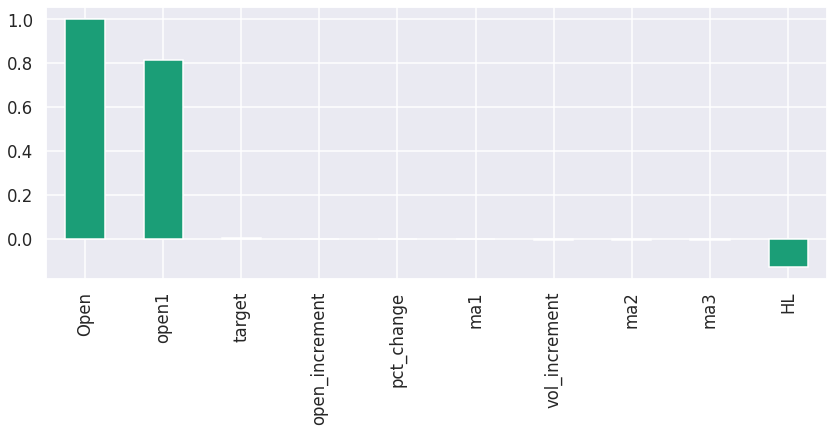

In [67]:
# Checking Correlation 
sns.set(style='darkgrid', context='talk', palette='Dark2')
plt.figure(figsize=(14,5))
dataset.corr()['Open'].sort_values(ascending = False).plot(kind='bar')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

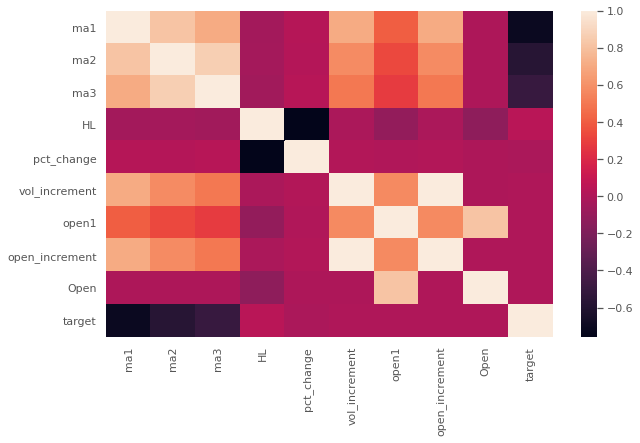

In [19]:
# Compute the correlation matrix
corr = dataset.corr()
sns.heatmap(corr)
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.show()

In [68]:
print('Total dataset has {} samples, and {} features.'.format(dataset.shape[0], dataset.shape[1]))

Total dataset has 5158 samples, and 10 features.


In [21]:
X = (dataset.drop(['target'], 1))
y = (dataset['target'])
print(len(X), len(y))

5158 5158


In [49]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split, TimeSeriesSplit

X = np.array(dataset.drop(['target', 'open1'], 1))
y = np.array(dataset['target'])

tscv = TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_samples, test_samples in tscv.split(X):
  #print("TRAIN:", train_samples, "TEST:", test_samples)
  X_train, X_test = X[train_samples], X[test_samples]
  y_train, y_test = y[train_samples], y[test_samples]

feature_names = ['ma1','ma2','ma3','HL','pct_change','vol_increment','open_increment','Open']
X_train = pd.DataFrame(data=X_train, columns=feature_names)
X_test = pd.DataFrame(data=X_test, columns=feature_names)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(4299, 8) (4299,)
(859, 8) (859,)


In [ ]:
X_train, X_test, y_train, y_test

The target variables will be transformed for binary classification. A positive change in the value of prices will be classified as 1 and a non-positive change as 0.

In [50]:
y_train = pd.DataFrame(y_train)
y_train.rename(columns = {0: 'target'}, inplace=True)

y_test = pd.DataFrame(y_test)
y_test.rename(columns = {0: 'target'}, inplace=True)

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
y_test_binary = pd.DataFrame(y_test["target"].apply(getBinary))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

and the transformation is applied on the test data for later use.
the train data will be transformed while it is being fit.

In [51]:
regressor = xgb.XGBRegressor(objective ='reg:squarederror',
                             gamma=0.0,
                             n_estimators=200,
                             base_score=0.7,
                             colsample_bytree=1,
                             learning_rate=0.01)
regressor


<IPython.core.display.Javascript object>

XGBRegressor(base_score=0.7, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [52]:
xgb_model = regressor.fit(X_train, y_train.target.apply(getBinary))
y_predicted = xgb_model.predict(X_test)
y_predicted_binary = [1 if yp > 0.5 else 0 for yp in y_predicted]
accuracy = (accuracy_score(y_test_binary,y_predicted_binary))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.81%


***So, the initial accuracy without optimizing the model is 78.28% predicting the daily average price change for each of the the next 617 trading days***

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

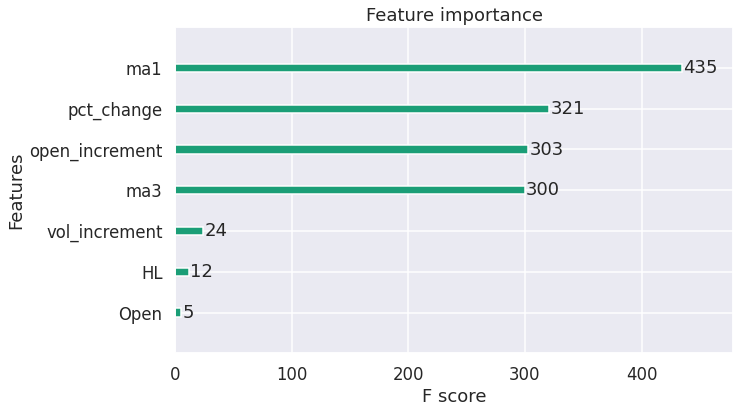

In [54]:
plt.rcParams['figure.figsize'] = [10,6]
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_model)
plt.show()

In [56]:
pip install shap

     |████████████████████████████████| 276kB 6.5MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394119 sha256=b3a894d6f652cc58b3b274b08ae4d156315fe4cb1f94060d429c6d9b6a30f42e
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


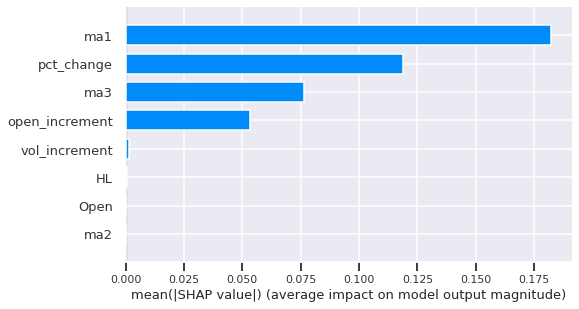

In [57]:
import shap
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")